In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

**Data Collection and Preprocessing**

In [ ]:
!wget https://github.com/uditdas84/Datasets/raw/main/PlantVillage.zip
!unzip PlantVillage.zip

--2023-07-13 17:12:17--  https://github.com/uditdas84/Datasets/raw/main/PlantVillage.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/uditdas84/Datasets/main/PlantVillage.zip [following]
--2023-07-13 17:12:17--  https://raw.githubusercontent.com/uditdas84/Datasets/main/PlantVillage.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21315583 (20M) [application/zip]
Saving to: ‘PlantVillage.zip’

PlantVillage.zip    100%[===================>]  20.33M  --.-KB/s    in 0.1s    

2023-07-13 17:12:18 (155 MB/s) - ‘PlantVillage.zip’ saved [21315583/21315583]

Archive:  PlantVillage.zip
   creating: 

In [ ]:
import os
os.mkdir("PlantVillage")

In [ ]:
import shutil

# Source path
sources = ["/content/Potato___Early_blight",
          "/content/Potato___Late_blight",
          "/content/Potato___healthy"]

# Destination path
destination = "/content/PlantVillage"

# Move the content of
# source to destination
for source in sources:
  dest = shutil.move(source, destination)

# print(dest) prints the
# Destination of moved directory

In [ ]:
image_size=256
batch_size=12
channal=3
epochs=20

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size = batch_size
)

Found 1152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

96

In [ ]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0])
    print(label_batch[0])

tf.Tensor(
[[[165. 168. 185.]
  [165. 168. 185.]
  [171. 174. 191.]
  ...
  [ 89.  86. 105.]
  [ 77.  74.  93.]
  [121. 118. 137.]]

 [[166. 169. 186.]
  [163. 166. 183.]
  [165. 168. 185.]
  ...
  [ 99.  96. 115.]
  [160. 157. 176.]
  [101.  98. 117.]]

 [[171. 174. 191.]
  [166. 169. 186.]
  [166. 169. 186.]
  ...
  [134. 131. 150.]
  [106. 103. 122.]
  [123. 120. 139.]]

 ...

 [[145. 146. 164.]
  [147. 148. 166.]
  [152. 153. 171.]
  ...
  [121. 116. 136.]
  [149. 144. 164.]
  [ 97.  92. 112.]]

 [[151. 152. 170.]
  [147. 148. 166.]
  [146. 147. 165.]
  ...
  [108. 103. 123.]
  [131. 126. 146.]
  [124. 119. 139.]]

 [[175. 176. 194.]
  [164. 165. 183.]
  [156. 157. 175.]
  ...
  [117. 112. 132.]
  [118. 113. 133.]
  [106. 101. 121.]]], shape=(256, 256, 3), dtype=float32)
tf.Tensor(0, shape=(), dtype=int32)


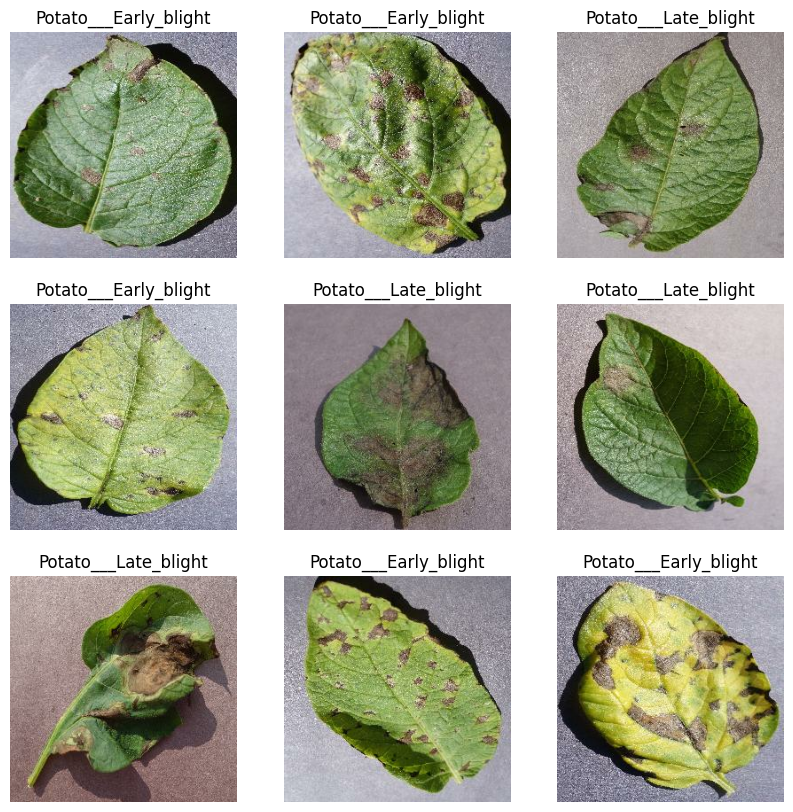

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
# 80% ==> training data
# 10% ==> validation
# 10 ==> test

train_size = 0.8
train_size= len(dataset)*train_size
train_size=int(train_size)

In [ ]:
train_ds = dataset.take(train_size)

In [ ]:
test_ds =  dataset.skip(train_size)
len(test_ds)

20

In [ ]:
val_size = 0.1
val_size = int(len(dataset)*val_size)
val_size

9

In [ ]:
val_ds = test_ds.take(val_size)
test_ds = test_ds.skip(val_size)

In [ ]:
def get_dataset_split_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds= ds.shuffle(shuffle_size,seed= 12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_split_tf(dataset)

In [ ]:
len(train_ds)

76

In [ ]:
len(test_ds)

11

In [ ]:
len(val_ds)

9

In [ ]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

**Model Training**

In [ ]:
input_shape = (batch_size,image_size, image_size,channal)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (12, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (12, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (12, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (12, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (12, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (12, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
76/76 [==============================] - 24s 61ms/step - loss: 0.9820 - accuracy: 0.4879 - val_loss: 0.8429 - val_accuracy: 0.5278
Epoch 2/20
76/76 [==============================] - 4s 56ms/step - loss: 0.6700 - accuracy: 0.6985 - val_loss: 0.5356 - val_accuracy: 0.7407
Epoch 3/20
76/76 [==============================] - 3s 44ms/step - loss: 0.5038 - accuracy: 0.7851 - val_loss: 0.5032 - val_accuracy: 0.8333
Epoch 4/20
76/76 [==============================] - 3s 42ms/step - loss: 0.3743 - accuracy: 0.8575 - val_loss: 0.3419 - val_accuracy: 0.8611
Epoch 5/20
76/76 [==============================] - 4s 49ms/step - loss: 0.3151 - accuracy: 0.8695 - val_loss: 0.3610 - val_accuracy: 0.8611
Epoch 6/20
76/76 [==============================] - 3s 43ms/step - loss: 0.3242 - accuracy: 0.8673 - val_loss: 0.4001 - val_accuracy: 0.8426
Epoch 7/20
76/76 [==============================] - 3s 42ms/step - loss: 0.2756 - accuracy: 0.8882 - val_loss: 0.3198 - val_accuracy: 0.8796
Epoch 8/20
7

Model Evaluation

In [ ]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 1s 13ms/step - loss: 0.1653 - accuracy: 0.9545


In [ ]:
scores

[0.16530056297779083, 0.9545454382896423]

In [ ]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 76}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

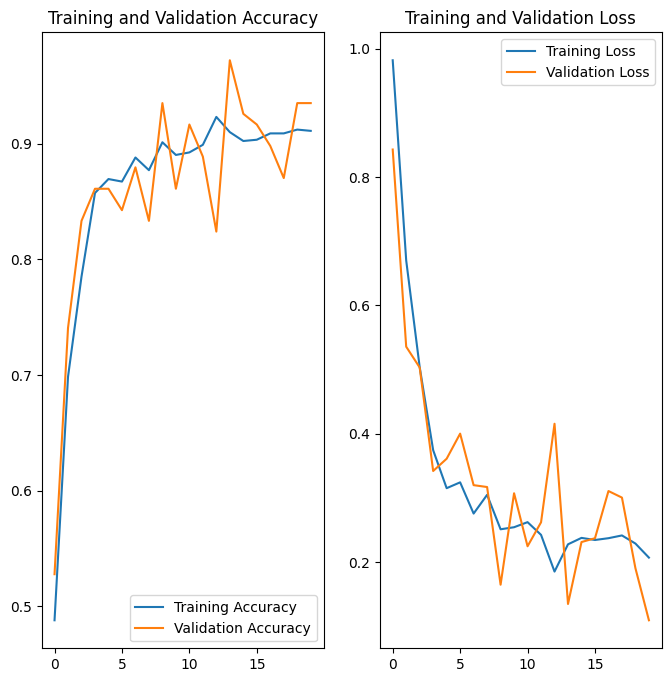

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model Prediction

In [ ]:
import numpy as np

actual label:  Potato___Early_blight
first image to predict
1/1 [==============================] - 0s 27ms/step
Potato___Early_blight


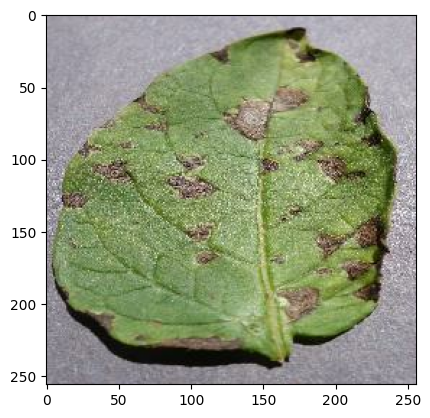

In [ ]:
for images_batch,labels_batch in test_ds.take(1):
  first_image= images_batch[0].numpy().astype("uint8")
  first_label = labels_batch[0].numpy()
  print("actual label: ", class_names[first_label])


  print("first image to predict")
  plt.imshow(first_image)
  pred_img = model.predict(images_batch)
  print(class_names[np.argmax(pred_img[0])])
  # print(pred_img[0])


In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


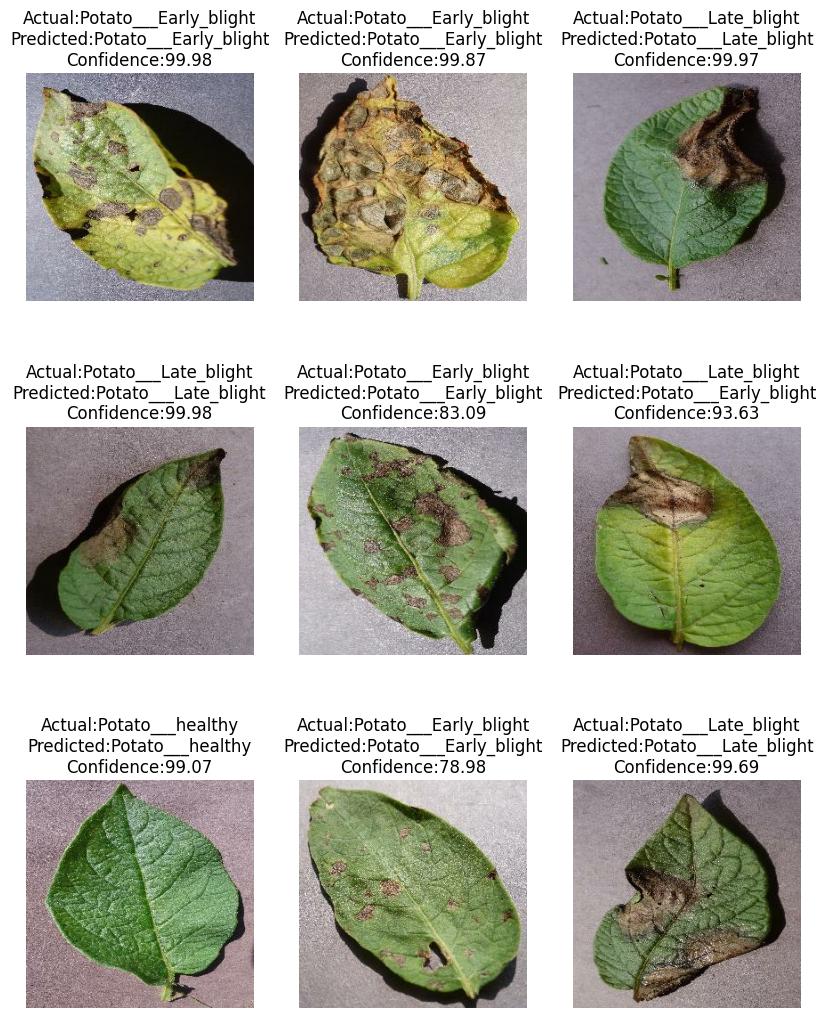

In [ ]:
plt.figure(figsize=(10,13))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class,confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual:{actual_class}\nPredicted:{predicted_class}\nConfidence:{confidence}")
    plt.axis("off")

In [ ]:
# import os
# os.mkdir("models")

In [ ]:
!pwd

/content


In [ ]:

model_version=1
model.save(f"/content/models/{model_version}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/models

/content/models


In [ ]:
!zip -r 1.zip 1/

  adding: 1/ (stored 0%)
  adding: 1/fingerprint.pb (stored 0%)
  adding: 1/variables/ (stored 0%)
  adding: 1/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: 1/variables/variables.index (deflated 68%)
  adding: 1/keras_metadata.pb (deflated 94%)
  adding: 1/assets/ (stored 0%)
  adding: 1/saved_model.pb (deflated 89%)


In [ ]:
from google.colab import files
files.download('1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>